# MinMax with alpha-beta pruning used to play Connect Four

Structure
```
├── LICENSE
├── README.md
├── minimax.ipynb
├── test
│   ├── __init__.py
│   ├── test_connect_four.py
│   ├── test_dots_and_boxes.py
│   └── test_pick.py
└── two_player_games
    ├── __init__.py
    ├── games
    │   ├── connect_four.py
    │   └── dots_and_boxes.py
    ├── move.py
    ├── player.py
    └── state.py
```

In [1]:
from typing import Tuple, List, Callable
import matplotlib.pyplot as plt
from two_player_games.player import Player
from two_player_games.games.connect_four import ConnectFour, ConnectFourMove, ConnectFourState

Size of the board

In [2]:
ROW_COUNT = 6
COLUMN_COUNT = 7

#   Solver

In [3]:
class MinMaxSolver:

    def __init__(self, game: ConnectFour, heuristic: Callable, depth: int = 4):
        self.game = game
        self.heuristic = heuristic
        self.depth = depth

    def get_best_move(self)->int:
        return self.minimax(self.depth, float('-inf'), float('inf'), True, None)[0]

    def is_valid_move(self, col_index:int)->bool:
        return self.game.is_valid_move(ConnectFourMove(col_index))
    
    def minimax(self, depth, alpha:float, beta:float, is_maximizing_player:bool, last_move: ConnectFourMove)-> Tuple[int, float]:
        valid_moves = self.game.get_moves()
        if depth == 0 or self.game.is_finished() or not valid_moves:
            score = self.game.get_score(self.heuristic) if is_maximizing_player else -self.game.get_score(self.heuristic)
            return None, score
        
        if is_maximizing_player:
            value = float('-inf')
            best_move = None
            for move in valid_moves:
                self.game.make_move(move)
                new_value = self.minimax(depth-1, alpha, beta, False, move)[1]
                self.game.undo_move(move)
                if new_value > value or not best_move:
                    value = new_value
                    best_move = move
                alpha = max(alpha, value)
                if alpha >= beta:
                    break
            return best_move, value
        else:
            value = float('inf')
            best_move = None
            for move in valid_moves:
                self.game.make_move(move)
                new_value = self.minimax(depth-1, alpha, beta, True, move)[1]
                self.game.undo_move(move)
                if new_value < value or not best_move:
                    value = new_value
                    best_move = move
                beta = min(beta, value)
                if alpha >= beta:
                    break
            return best_move, value
        

| **Heuristic**   | **Focus**                          | **Scoring Method**                                                                                                                                                       | **Strengths**                                                | **Weaknesses**                                                   |
|------------------|------------------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------|-------------------------------------------------------------|------------------------------------------------------------------|
| **`heuristic1`** | Balanced threats and opportunities| - Evaluates token patterns for both players in all directions.<br> - Scores based on: <br> **3 tokens + 1 empty**: +5<br> **2 tokens + 2 empty**: +2<br> **1 token + 3 empty**: +1.<br> - Opponent’s score is subtracted. | - Balances offense and defense.<br> - Handles early/mid-game effectively. | - Can overvalue incomplete sequences.<br> - Limited focus on imminent wins. |
| **`heuristic2`** | Blocking opponent’s threats       | - Same structure as `heuristic1`, but uses higher weights:<br> **3 tokens + 1 empty**: +10<br> **2 tokens + 2 empty**: +3<br> **1 token + 3 empty**: +1.<br> - Opponent’s score weighted more heavily (multiplied by 1.5). | - Strong emphasis on blocking opponent threats.<br> - Encourages defensive play. | - May undervalue offensive opportunities.<br> - Slightly more defensive than balanced. |
| **`heuristic3`** | Flexible configurations           | - Evaluates all valid 4-cell sequences.<br> - Scores each valid sequence as `1` if the total tokens + empty spaces = 4 (viable configuration).<br> - Focuses equally on both players. | - Identifies long-term winning potential.<br> - Simplified evaluation logic. | - Lacks prioritization of critical states.<br> - Ignores token patterns outside viable groups. |
| **`heuristic4`** | Explicit winning rows             | - Explicitly evaluates **all possible 4-cell groups**:<br> - Horizontal, vertical, and diagonal rows.<br> - Scores groups as `1` if tokens + empty spaces = 4.<br> - Focuses equally on both players. | - Strong focus on imminent wins.<br> - Computationally efficient due to limited group evaluation.<br> - Well-suited for late-game scenarios. | - Ignores incomplete sequences early on.<br> - Less useful in the early/mid-game. |


In [23]:
def get_direction(col, row) -> List[Tuple[int, int]]:
    return [(1, 0), (-1, 0), (0, 1), (0, -1), (1, 1), (-1, -1), (1, -1), (-1, 1)]


def heuristic1(state: ConnectFourState) -> float:
    current_player = state.get_current_player()
    other_player = state.get_other_player()
    visited = set()
    
    def count_sequences(player: Player) -> int:
        score = 0
        for col in range(len(state.fields)):
            for row in range(len(state.fields[0])):
                # Count sequences of player tokens in each direction
                if state.fields[col][row] == player and (col, row) not in visited:
                    visited.add((col, row))
                    for direction in get_direction(col, row):
                        score += count_in_direction(player, (col, row), direction)
        return score

    def count_in_direction(player: Player, start: Tuple[int, int], direction: Tuple[int, int]) -> int:
        consecutive_count = 0
        empty_spaces = 0
        for i in range(4):
            col = start[0] + direction[0] * i
            row = start[1] + direction[1] * i
            
            if col < 0 or col >= len(state.fields) or row < 0 or row >= len(state.fields[0]):
                return 0
            
            if state.fields[col][row] == player:
                consecutive_count += 1
            elif state.fields[col][row] is None:
                empty_spaces += 1
            else:
                return 0  # Blocked by opponent's token
        
        if consecutive_count == 3 and empty_spaces == 1:
            return 5  # Three in a row with space to win
        elif consecutive_count == 2 and empty_spaces == 2:
            return 2  # Two in a row with two open spaces
        elif consecutive_count == 1 and empty_spaces == 3:
            return 1  # One in a row with three open spaces
        return 0

    # Score for current player minus score for opponent
    return count_sequences(current_player) - count_sequences(other_player)


def heuristic2(state: ConnectFourState) -> float:
    current_player = state.get_current_player()
    other_player = state.get_other_player()
    visited = set()

    def evaluate_position(player: Player) -> int:
        score = 0
        # Only start from cells where four tokens can fit in the specified direction
        for col in range(len(state.fields)):
            for row in range(len(state.fields[0])):
                if state.fields[col][row] == player and (col, row) not in visited:
                    visited.add((col, row))
                    for direction in get_direction(col, row):
                        score += evaluate_direction(player, (col, row), direction)
        return score

    def evaluate_direction(player: Player, start: Tuple[int, int], direction: Tuple[int, int]) -> int:
        consecutive_count = 0
        empty_spaces = 0
        for i in range(4):
            col = start[0] + direction[0] * i
            row = start[1] + direction[1] * i

            if col < 0 or col >= len(state.fields) or row < 0 or row >= len(state.fields[0]):
                return 0
            
            if state.fields[col][row] == player:
                consecutive_count += 1
            elif state.fields[col][row] is None:
                empty_spaces += 1
            else:
                return 0  # Blocked by opponent's token

        # Assign scores based on the configuration of consecutive tokens and empty spaces
        if consecutive_count == 3 and empty_spaces == 1:
            return 10   # Three in a row with one space
        elif consecutive_count == 2 and empty_spaces == 2:
            return 3    # Two in a row with two spaces
        elif consecutive_count == 1 and empty_spaces == 3:
            return 1    # One in a row with three spaces
        return 0

    # Calculate and return the adjusted heuristic score
    current_score = evaluate_position(current_player)
    opponent_score = evaluate_position(other_player)
    
    return current_score - 1.5 * opponent_score


def heuristic3(state: ConnectFourState) -> float:
    current_player = state.get_current_player()
    other_player = state.get_other_player()
    visited = set()

    def evaluate_position(player: Player) -> int:
        score = 0
        cols = len(state.fields)
        rows = len(state.fields[0])

        # Only start from cells where four tokens can fit in the specified direction
        for col in range(cols):
            for row in range(rows):
                if state.fields[col][row] == player and (col, row) not in visited:
                    visited.add((col, row))
                    for direction in get_direction(col, row):
                        score += evaluate_direction(player, (col, row), direction)
        return score

    def evaluate_direction(player: Player, start: Tuple[int, int], direction: Tuple[int, int]) -> int:
        consecutive_count = 0
        empty_spaces = 0
        for i in range(4):
            col = start[0] + direction[0] * i
            row = start[1] + direction[1] * i

            if col < 0 or col >= len(state.fields) or row < 0 or row >= len(state.fields[0]):
                return 0
            
            if state.fields[col][row] == player:
                consecutive_count += 1
            elif state.fields[col][row] is None:
                empty_spaces += 1
            else:
                return 0  # Blocked by opponent's token

        if consecutive_count + empty_spaces == 4:
            return 1
        return 0

    # Calculate and return the adjusted heuristic score
    current_score = evaluate_position(current_player)
    opponent_score = evaluate_position(other_player)

    return current_score - opponent_score

def heuristic4(state: ConnectFourState) -> float:
    current_player = state.get_current_player()
    other_player = state.get_other_player()
    visited = set()

    def evaluate_position(player: Player) -> int:
        score = 0
        cols = len(state.fields)
        rows = len(state.fields[0])

        # Check all possible fours in rows 
        for row in range(rows):
            for col in range(cols - 3):
                score += evaluate_direction(player, (col, row), (1, 0))
        
        # Check all possible fours in columns
        for col in range(cols):
            for row in range(rows - 3):
                score += evaluate_direction(player, (col, row), (0, 1))
        
        # Check all possible fours in diagonals
        for col in range(cols - 3):
            for row in range(rows - 3):
                score += evaluate_direction(player, (col, row), (1, 1))
                score += evaluate_direction(player, (col, row + 3), (1, -1))
        
        return score
        
    
    def evaluate_direction(player: Player, start: Tuple[int, int], direction: Tuple[int, int]) -> int:
        consecutive_count = 0
        empty_spaces = 0
        for i in range(4):
            col = start[0] + direction[0] * i
            row = start[1] + direction[1] * i

            if col < 0 or col >= len(state.fields) or row < 0 or row >= len(state.fields[0]):
                return 0
            
            if state.fields[col][row] == player:
                consecutive_count += 1
            elif state.fields[col][row] is None:
                empty_spaces += 1
            else:
                return 0
        
        return 1 if consecutive_count + empty_spaces == 4 else 0


    # Calculate and return the adjusted heuristic score
    current_score = evaluate_position(current_player)
    opponent_score = evaluate_position(other_player)

    return current_score - opponent_score

#   Visualisation

In [5]:
def plot_lead(x, y):
    plt.plot(x, y)
    plt.xlabel('Depth')
    plt.ylabel('Lead')
    plt.title('Lead of player 1 over player 2')
    plt.show()

h1_d4 = []
h2_d4 = []
h3_d4 = []
h4_d4 = []

h1_d6 = []
h2_d6 = []
h3_d6 = []
h4_d6 = []

h1_d2 = []
h2_d2 = []
h3_d2 = []
h4_d2 = []

Rozgrywka

# Depth = 4

#   Heuristic nr.1

In [6]:
p1 = Player("a")
p2 = Player("b")
game = ConnectFour(size=(COLUMN_COUNT, ROW_COUNT), first_player=p1, second_player=p2)
solver = MinMaxSolver(game, heuristic1)
i = 0
while not game.is_finished():
    game.make_move(solver.get_best_move())
    x = heuristic1(game.get_state()) * (-1 ** i)
    h1_d4.append(x)
    print(x)
    print(game)
    i += 1

5
Current player: b
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
1
Current player: a
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][b][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
5
Current player: b
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
[ ][ ][ ][b][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
-1
Current player: a
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
[ ][ ][ ][b][ ][ ][ ]
[ ][ ][b][a][ ][ ][ ]
7
Current player: b
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
[ ][ ][a][b][ ][ ][ ]
[ ][ ][b][a][ ][ ][ ]
-2
Current player: a
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][b][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
[ ][ ][a][b][ ][ ][ ]
[ ][ ][b][a][ ][ ][ ]
9
Current player: b
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][b][ ][ ][ ]


#   Heuristic nr.2

In [7]:
p1 = Player("a")
p2 = Player("b")
game = ConnectFour(size=(COLUMN_COUNT, ROW_COUNT), first_player=p1, second_player=p2)
solver = MinMaxSolver(game, heuristic2)
i = 0
while not game.is_finished():
    game.make_move(solver.get_best_move())
    x = heuristic2(game.get_state()) * (-1 ** i)
    h2_d4.append(x)
    print(x)
    print(game)
    i += 1

7.5
Current player: b
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
-1.0
Current player: a
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][b][ ][a][ ][ ][ ]
10.0
Current player: b
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][b][ ][a][a][ ][ ]
1.0
Current player: a
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][b][ ][a][a][b][ ]
15.0
Current player: b
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][a][ ][ ]
[ ][b][ ][a][a][b][ ]
1.5
Current player: a
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][b][a][ ][ ]
[ ][b][ ][a][a][b][ ]
25.5
Current player: b
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ]

#   Heuristic nr.3

In [8]:
p1 = Player("a")
p2 = Player("b")
game = ConnectFour(size=(COLUMN_COUNT, ROW_COUNT), first_player=p1, second_player=p2)
solver = MinMaxSolver(game, heuristic3)
i = 0
while not game.is_finished():
    game.make_move(solver.get_best_move())
    x = heuristic3(game.get_state()) * (-1 ** i)
    h3_d4.append(x)
    print(x)
    print(game)
    i += 1

5
Current player: b
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
1
Current player: a
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][b][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
5
Current player: b
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
[ ][ ][ ][b][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
0
Current player: a
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][b][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
[ ][ ][ ][b][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
3
Current player: b
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][b][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
[ ][ ][ ][b][ ][ ][ ]
[a][ ][ ][a][ ][ ][ ]
1
Current player: a
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][b][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
[b][ ][ ][b][ ][ ][ ]
[a][ ][ ][a][ ][ ][ ]
3
Current player: b
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][b][ ][ ][ ]
[a

#   Heuristic nr.4

In [9]:
p1 = Player("a")
p2 = Player("b")
game = ConnectFour(size=(COLUMN_COUNT, ROW_COUNT), first_player=p1, second_player=p2)
solver = MinMaxSolver(game, heuristic4)
i = 0
while not game.is_finished():
    game.make_move(solver.get_best_move())
    x = heuristic3(game.get_state()) * (-1 ** i)
    h4_d4.append(x)
    print(x)
    print(game)
    i += 1

5
Current player: b
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
1
Current player: a
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][b][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
5
Current player: b
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
[ ][ ][ ][b][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
0
Current player: a
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][b][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
[ ][ ][ ][b][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
4
Current player: b
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
[ ][ ][ ][b][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
[ ][ ][ ][b][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
0
Current player: a
[ ][ ][ ][b][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
[ ][ ][ ][b][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
[ ][ ][ ][b][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
2
Current player: b
[ ][ ][ ][b][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
[ ][ ][ ][b][ ][ ][ ]
[ 

# Depth = 6

#   Heuristic nr.1

In [10]:
p1 = Player("a")
p2 = Player("b")
game = ConnectFour(size=(COLUMN_COUNT, ROW_COUNT), first_player=p1, second_player=p2)
solver = MinMaxSolver(game, heuristic1, depth = 6)
i = 0
while not game.is_finished():
    game.make_move(solver.get_best_move())
    x = heuristic2(game.get_state()) * (-1 ** i)
    h1_d6.append(x)
    print(x)
    print(game)
    i += 1

7.5
Current player: b
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
3.5
Current player: a
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][b][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
9.5
Current player: b
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
[ ][ ][ ][b][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
4.0
Current player: a
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][b][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
[ ][ ][ ][b][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
10.0
Current player: b
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
[ ][ ][ ][b][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
[ ][ ][ ][b][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
7.0
Current player: a
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
[ ][ ][ ][b][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
[ ][ ][ ][b][ ][ ][ ]
[ ][ ][b][a][ ][ ][ ]
15.5
Current player: b
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
[ ][ ][ 

#   Heuristic nr.2

In [11]:
p1 = Player("a")
p2 = Player("b")
game = ConnectFour(size=(COLUMN_COUNT, ROW_COUNT), first_player=p1, second_player=p2)
solver = MinMaxSolver(game, heuristic2, depth=6)
i = 0
while not game.is_finished():
    game.make_move(solver.get_best_move())
    x = heuristic2(game.get_state()) * (-1 ** i)
    h2_d6.append(x)
    print(x)
    print(game)
    i += 1

7.5
Current player: b
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
-1.0
Current player: a
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][b][a][ ][ ][ ]
15.5
Current player: b
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
[ ][ ][b][a][ ][ ][ ]
2.0
Current player: a
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][b][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
[ ][ ][b][a][ ][ ][ ]
11.5
Current player: b
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
[ ][ ][ ][b][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
[ ][ ][b][a][ ][ ][ ]
-0.0
Current player: a
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
[ ][ ][ ][b][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
[ ][ ][b][a][ ][ ][b]
20.5
Current player: b
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ 

#   Heuristic nr.3

In [12]:
p1 = Player("a")
p2 = Player("b")
game = ConnectFour(size=(COLUMN_COUNT, ROW_COUNT), first_player=p1, second_player=p2)
solver = MinMaxSolver(game, heuristic3, depth=6)
i = 0
while not game.is_finished():
    game.make_move(solver.get_best_move())
    x = heuristic3(game.get_state()) * (-1 ** i)
    h3_d6.append(x)
    print(x)
    print(game)
    i += 1

5
Current player: b
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
1
Current player: a
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][b][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
2
Current player: b
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][b][ ][ ][ ]
[a][ ][ ][a][ ][ ][ ]
3
Current player: a
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][b][ ][ ][ ]
[ ][ ][ ][b][ ][ ][ ]
[a][ ][ ][a][ ][ ][ ]
3
Current player: b
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
[ ][ ][ ][b][ ][ ][ ]
[ ][ ][ ][b][ ][ ][ ]
[a][ ][ ][a][ ][ ][ ]
1
Current player: a
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
[ ][ ][ ][b][ ][ ][ ]
[ ][ ][ ][b][ ][ ][ ]
[a][ ][b][a][ ][ ][ ]
2
Current player: b
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
[ 

#   Heuristic nr.4

In [13]:
p1 = Player("a")
p2 = Player("b")
game = ConnectFour(size=(COLUMN_COUNT, ROW_COUNT), first_player=p1, second_player=p2)
solver = MinMaxSolver(game, heuristic4, depth=6)
i = 0
while not game.is_finished():
    game.make_move(solver.get_best_move())
    x = heuristic3(game.get_state()) * (-1 ** i)
    h4_d6.append(x)
    print(x)
    print(game)
    i += 1

5
Current player: b
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
1
Current player: a
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][b][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
1
Current player: b
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][b][ ][ ][ ]
[ ][ ][a][a][ ][ ][ ]
3
Current player: a
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][b][ ][ ][ ]
[ ][ ][a][a][b][ ][ ]
3
Current player: b
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
[ ][ ][ ][b][ ][ ][ ]
[ ][ ][a][a][b][ ][ ]
2
Current player: a
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][b][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
[ ][ ][ ][b][ ][ ][ ]
[ ][ ][a][a][b][ ][ ]
1
Current player: b
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][b][ ][ ][ ]
[ 

#   Depth = 2

#   Heuristic nr.1

In [14]:
p1 = Player("a")
p2 = Player("b")
game = ConnectFour(size=(COLUMN_COUNT, ROW_COUNT), first_player=p1, second_player=p2)
solver = MinMaxSolver(game, heuristic1, depth=2)
i = 0
while not game.is_finished():
    game.make_move(solver.get_best_move())
    x = heuristic1(game.get_state()) * (-1 ** i)
    h1_d2.append(x)
    print(x)
    print(game)
    i += 1

5
Current player: b
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
1
Current player: a
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][b][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
5
Current player: b
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
[ ][ ][ ][b][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
0
Current player: a
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][b][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
[ ][ ][ ][b][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
4
Current player: b
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
[ ][ ][ ][b][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
[ ][ ][ ][b][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
1
Current player: a
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
[ ][ ][ ][b][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
[ ][ ][ ][b][ ][ ][ ]
[b][ ][ ][a][ ][ ][ ]
5
Current player: b
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
[ ][ ][ ][b][ ][ ][ ]
[ 

#   Heuristic nr.2

In [15]:
p1 = Player("a")
p2 = Player("b")
game = ConnectFour(size=(COLUMN_COUNT, ROW_COUNT), first_player=p1, second_player=p2)
solver = MinMaxSolver(game, heuristic2, depth=2)
i = 0
while not game.is_finished():
    game.make_move(solver.get_best_move())
    x = heuristic2(game.get_state()) * (-1 ** i)
    h2_d2.append(x)
    print(x)
    print(game)
    i += 1

7.5
Current player: b
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
3.5
Current player: a
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][b][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
9.5
Current player: b
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
[ ][ ][ ][b][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
4.0
Current player: a
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
[ ][ ][ ][b][ ][ ][ ]
[ ][ ][b][a][ ][ ][ ]
15.0
Current player: b
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
[ ][ ][a][b][ ][ ][ ]
[ ][ ][b][a][ ][ ][ ]
3.0
Current player: a
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][b][a][ ][ ][ ]
[ ][ ][a][b][ ][ ][ ]
[ ][ ][b][a][ ][ ][ ]
24.5
Current player: b
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ 

#   Heuristic nr.3

In [16]:
p1 = Player("a")
p2 = Player("b")
game = ConnectFour(size=(COLUMN_COUNT, ROW_COUNT), first_player=p1, second_player=p2)
solver = MinMaxSolver(game, heuristic3, depth=2)
i = 0
while not game.is_finished():
    game.make_move(solver.get_best_move())
    x = heuristic3(game.get_state()) * (-1 ** i)
    h3_d2.append(x)
    print(x)
    print(game)
    i += 1

5
Current player: b
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
1
Current player: a
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][b][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
5
Current player: b
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
[ ][ ][ ][b][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
0
Current player: a
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][b][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
[ ][ ][ ][b][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
4
Current player: b
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
[ ][ ][ ][b][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
[ ][ ][ ][b][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
0
Current player: a
[ ][ ][ ][b][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
[ ][ ][ ][b][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
[ ][ ][ ][b][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
3
Current player: b
[ ][ ][ ][b][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
[ ][ ][ ][b][ ][ ][ ]
[ 

#   Heuristic nr.4

In [17]:
p1 = Player("a")
p2 = Player("b")
game = ConnectFour(size=(COLUMN_COUNT, ROW_COUNT), first_player=p1, second_player=p2)
solver = MinMaxSolver(game, heuristic4, depth=2)
i = 0
while not game.is_finished():
    game.make_move(solver.get_best_move())
    x = heuristic3(game.get_state()) * (-1 ** i)
    h4_d2.append(x)
    print(x)
    print(game)
    i += 1

3
Current player: b
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][a][ ][ ][ ][ ][ ]
1
Current player: a
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][b][ ][ ][ ][ ][ ]
[ ][a][ ][ ][ ][ ][ ]
3
Current player: b
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][a][ ][ ][ ][ ][ ]
[ ][b][ ][ ][ ][ ][ ]
[ ][a][ ][ ][ ][ ][ ]
0
Current player: a
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][b][ ][ ][ ][ ][ ]
[ ][a][ ][ ][ ][ ][ ]
[ ][b][ ][ ][ ][ ][ ]
[ ][a][ ][ ][ ][ ][ ]
5
Current player: b
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][b][ ][ ][ ][ ][ ]
[ ][a][ ][ ][ ][ ][ ]
[ ][b][ ][ ][ ][ ][ ]
[ ][a][ ][a][ ][ ][ ]
1
Current player: a
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][b][ ][ ][ ][ ][ ]
[ ][a][ ][ ][ ][ ][ ]
[ ][b][ ][b][ ][ ][ ]
[ ][a][ ][a][ ][ ][ ]
5
Current player: b
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][b][ ][ ][ ][ ][ ]
[ 

#   Graphs visualising lead

In [18]:
print(h1_d4)
print(h1_d6)
print(h1_d2)

[5, 1, 5, -1, 7, -2, 9, -2, 5, -2, 8, -3, 6, -1, 7, -1, 6, -2, 6, -4, 17, -5, 6, -6, 7, 9, 21, -19, 21]
[7.5, 3.5, 9.5, 4.0, 10.0, 7.0, 15.5, 12.0, 17.0, 7.5, 17.5, 29.5, 27.5, 14.5, 30.0, 11.5, 51.5, 4.5, 16.0, 12.5, 33.5, 37.0, 24.5, 14.0, 27.5, -2.0, 16.5, 7.0, 20.5, -7.0, 18.0, -2.5, 16.0, 24.5, 15.5, 6.0, -4.0, 6.0, 1.5, -0.0, -0.0, -0.0]
[5, 1, 5, 0, 4, 1, 5, 0, 6, -2, 7, -1, 7, 0, 4, 0, 4, -1, 5, -4, 10, 0, 7, -3, 7, -4, 8, -4, 7, -4, 10, 0, 7, 3, -1, 1, 1, 1, 0, 0, 0, 0]


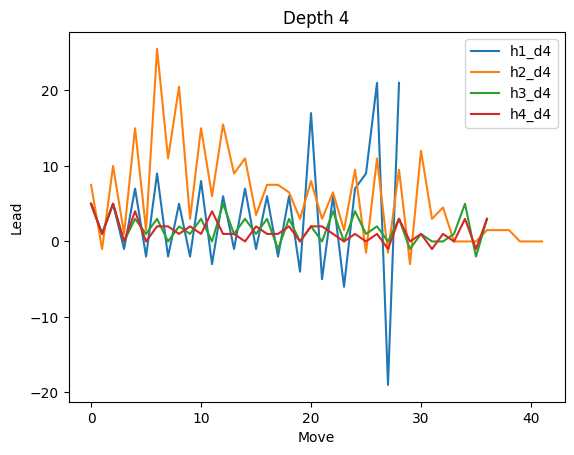

In [19]:
plt.plot([i for i in range(len(h1_d4))], h1_d4, label='h1_d4')
plt.plot([i for i in range(len(h2_d4))], h2_d4, label='h2_d4')
plt.plot([i for i in range(len(h3_d4))], h3_d4, label='h3_d4')
plt.plot([i for i in range(len(h4_d4))], h4_d4, label='h4_d4')
plt.xlabel('Move')
plt.ylabel('Lead')
plt.title('Depth 4')
plt.legend()

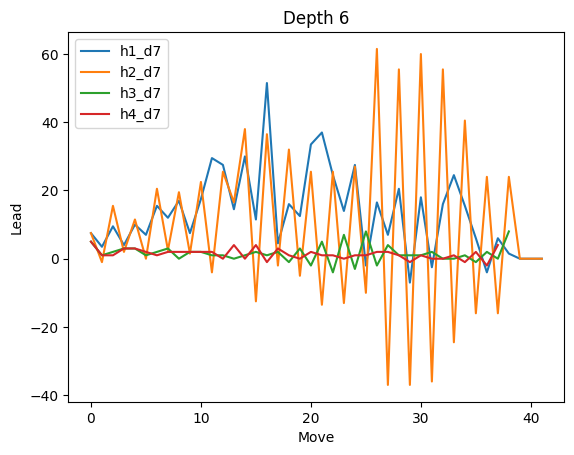

In [20]:
plt.plot([i for i in range(len(h1_d6))], h1_d6, label='h1_d7')
plt.plot([i for i in range(len(h2_d6))], h2_d6, label='h2_d7')
plt.plot([i for i in range(len(h3_d6))], h3_d6, label='h3_d7')
plt.plot([i for i in range(len(h4_d6))], h4_d6, label='h4_d7')
plt.xlabel('Move')
plt.ylabel('Lead')
plt.title('Depth 6')
plt.legend()

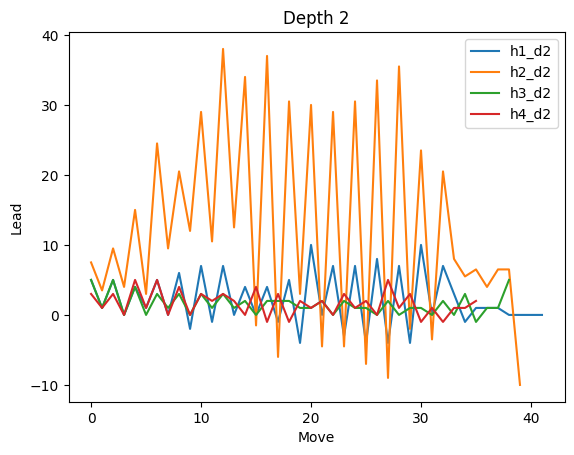

In [22]:
plt.plot([i for i in range(len(h1_d2))], h1_d2, label='h1_d2')
plt.plot([i for i in range(len(h2_d2))], h2_d2, label='h2_d2')
plt.plot([i for i in range(len(h3_d2))], h3_d2, label='h3_d2')
plt.plot([i for i in range(len(h4_d2))], h4_d2, label='h4_d2')
plt.xlabel('Move')
plt.ylabel('Lead')
plt.title('Depth 2')
plt.legend()